# Activations & Gradients, BatchNorm

We dive into some of the internals of MLPs with multiple layers and scrutinize the statistics of the forward pass activations, backward pass gradients, and some of the pitfalls when they are improperly scaled. We also look at the typical diagnostic tools and visualizations you'd want to use to understand the health of your deep network. We learn why training deep neural nets can be fragile and introduce the first modern innovation that made doing so much easier: Batch Normalization. Residual connections and the Adam optimizer remain notable todos for later video. 


Intuitive understanding of activation during training, and esp. grads flowing backwards and how they behave and what they look like. RNNs very expressive / universal approximators, we will see that they are not easy to optimize with first order methods. 

key to understanding: activation, gradients, and how they behave during training. Variants since RNNs (2011) have tried to improve that situation. That will be our path in this notebook


In [1]:
import torch
import torch.nn.functional as F

import math
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42
TRAIN_RATIO = 1.0

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

In [2]:
names = open(DATASET_DIR / 'names.txt', 'r').read().splitlines()
names = names[:int(TRAIN_RATIO * len(names))]

print(len(names))
names[:10]

32033


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
class CharDataset:
    def __init__(self, names, block_size):
        self.names = names
        self.vocab = ['.'] + sorted(list(set(''.join(names))))
        self.block_size = block_size
        self.itos = dict(enumerate(self.vocab))
        self.stoi = {c: i for i, c in self.itos.items()}

    def decode(self, x):
        return ''.join(self.itos[i] for i in x)

    def encode(self, word):
        return [self.stoi[c] for c in word]

    def build_dataset(self):
        """Creating subsequences -> next character target."""
        xs = []
        ys = []
        for name in self.names:
            context = ['.'] * self.block_size
            for c in name + '.':
                xs.append(self.encode(''.join(context)))
                ys.append(self.stoi[c])
                context = context[1:] + [c]
        
        return torch.tensor(xs), torch.tensor(ys)

In [4]:
import pandas as pd

dataset = CharDataset(names, block_size=3)
itos = dataset.itos
stoi = dataset.stoi

xs, ys = dataset.build_dataset()

df = pd.DataFrame({'xs': list(xs.numpy()), 'ys': list(ys.numpy())})
df['seq'] = df['xs'].apply(lambda x: ''.join(itos[c] for c in x))
df['target'] = df['ys'].map(itos)
df.head(12)

,xs,ys,seq,target
0,"[0, 0, 0]",5,...,e
1,"[0, 0, 5]",13,..e,m
2,"[0, 5, 13]",13,.em,m
3,"[5, 13, 13]",1,emm,a
4,"[13, 13, 1]",0,mma,.
5,"[0, 0, 0]",15,...,o
6,"[0, 0, 15]",12,..o,l
7,"[0, 15, 12]",9,.ol,i
8,"[15, 12, 9]",22,oli,v
9,"[12, 9, 22]",9,liv,i


In [5]:
from sklearn.model_selection import StratifiedKFold

def create_folds(xs, ys, seed=42):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    folds = torch.zeros(xs.shape[0])
    for fold, (trn_, val_) in enumerate(kf.split(xs, ys)):
        folds[val_] = fold

    xs_trn, ys_trn = xs[folds >  1], ys[folds >  1]
    xs_dev, ys_dev = xs[folds == 1], ys[folds == 1]
    xs_tst, ys_tst = xs[folds == 0], ys[folds == 0]

    return xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst



In [6]:
class MLP:
    def __init__(self, embedding_size, width, block_size, vocab_size=27, seed=2147483647):
        self.emb_size = embedding_size
        self.width = width
        self.blk_size = block_size
        self.vocab_size = vocab_size
        self._init_weights(seed)
        
    def _init_weights(self, seed):
        self.g = torch.Generator().manual_seed(seed)
        self.C  = torch.randn(self.vocab_size, self.emb_size,               generator=self.g)
        self.W1 = torch.randn((self.blk_size * self.emb_size, self.width),  generator=self.g)
        self.b1 = torch.randn(self.width,                                   generator=self.g)
        self.W2 = torch.randn((self.width, self.vocab_size),                generator=self.g)
        self.b2 = torch.randn(self.vocab_size,                              generator=self.g)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True

    def __call__(self, xs: list[int]):
        x = self.C[xs].view(-1, self.blk_size * self.emb_size)
        h = torch.tanh(x @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

    def zero_grad(self):
        for p in self.parameters:
           p.grad = None

    def optim_step(self, lr):
        for p in self.parameters:
           p.data -= lr * p.grad

In [13]:
def train_step(model, xs_trn, ys_trn, generator, batch_size=32, lr=0.1):
    """One step of backprop and weight update."""
    
    B = torch.randint(
        0, xs_trn.shape[0], 
        (batch_size,), 
        generator=generator
    )
    
    logits = model(xs_trn[B])
    loss = F.cross_entropy(logits, target=ys_trn[B])

    model.zero_grad()
    loss.backward()
    model.optim_step(lr=lr)

    return loss.item()


def train_model(
        model,
        xs_trn, ys_trn,
        xs_dev, ys_dev,
        batch_size,
        num_steps,
        lr=0.1,
        verbose=True, seed=42
    ):

    losses_trn = {}
    losses_dev = {}

    g = torch.Generator().manual_seed(seed)
    lr_counter = 0
    best_loss_dev = float("inf")
    print(f"Setting learning rate to {lr:.2e}")

    for k in range(num_steps):
        loss = train_step(model, xs_trn, ys_trn, g, batch_size, lr)
        losses_trn[k] = loss
        
        if (k % (num_steps // batch_size) == 0) or (k == num_steps - 1):
            with torch.no_grad():
                loss_dev = F.cross_entropy(model(xs_dev), ys_dev)
                losses_dev[k] = loss_dev.item()
            
            if verbose:
                print(f"[{k+1:>0{int(len(str(num_steps)))}d}/{num_steps}]      loss={loss:<8.4f}    dev_loss={loss_dev:.4f}")
    
            if loss_dev.item() < best_loss_dev:
                best_loss_dev = loss_dev.item()
                lr_counter = 0
            else:
                lr_counter += 1
                if lr_counter == 3:
                    lr *= 0.1
                    lr_counter = 0
                    if verbose:
                        print(f"Decreasing learning rate to {lr:.2e}")
                    
    return {"loss_trn": losses_trn, "loss_dev": losses_dev}

In [15]:
xs_trn, ys_trn, \
xs_dev, ys_dev, \
xs_tst, ys_tst = create_folds(xs, ys)

model = MLP(embedding_size=8, width=180, block_size=3)
hist = train_model(
    model, 
    xs_trn, ys_trn, 
    xs_dev, ys_dev, 
    batch_size=32, 
    num_steps=300000, 
    lr=0.2014206395146228, 
    verbose=True
)

Setting learning rate to 2.01e-01
[000001/300000]      loss=24.1149     dev_loss=23.2618
[009376/300000]      loss=2.9054      dev_loss=2.8677
[018751/300000]      loss=3.0840      dev_loss=2.5692
[028126/300000]      loss=2.4552      dev_loss=2.5369
[037501/300000]      loss=2.5357      dev_loss=2.6065
[046876/300000]      loss=2.6222      dev_loss=2.4017
[056251/300000]      loss=2.5329      dev_loss=2.4637
[065626/300000]      loss=2.4862      dev_loss=2.4841
[075001/300000]      loss=3.2175      dev_loss=2.5284
Decreasing learning rate to 2.01e-02
[084376/300000]      loss=2.1287      dev_loss=2.1713
[093751/300000]      loss=2.2897      dev_loss=2.1729
[103126/300000]      loss=1.9273      dev_loss=2.1669
[112501/300000]      loss=1.9314      dev_loss=2.1692
[121876/300000]      loss=2.2929      dev_loss=2.1664
[131251/300000]      loss=1.6294      dev_loss=2.1642
[140626/300000]      loss=1.7725      dev_loss=2.1652
[150001/300000]      loss=2.0152      dev_loss=2.1678
[159376/30

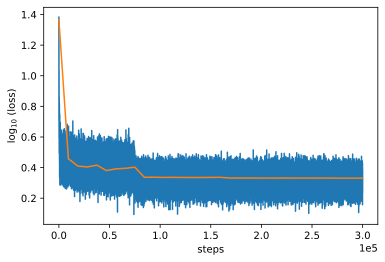

In [18]:
plt.plot(hist['loss_trn'].keys(), torch.tensor(list(hist['loss_trn'].values())).log10())
plt.plot(hist['loss_dev'].keys(), torch.tensor(list(hist['loss_dev'].values())).log10())

plt.xlabel("steps")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.ylabel("$\log_{10}$ (loss)");

In [19]:
@torch.no_grad()
def split_loss(model, split: str):
    x, y = {
        'train': (xs_trn, ys_trn),
        'valid': (xs_dev, ys_dev),
        'test':  (xs_tst, ys_tst)
    }[split]
    loss = F.cross_entropy(model(x), y)
    return loss.item()

print("train loss:", split_loss(model, 'train'))
print("valid loss:", split_loss(model, 'valid'))

train loss: 2.1101903915405273
valid loss: 2.1437699794769287


In [20]:
def generate_names(model, block_size: int, sample_size: int, seed=2147483647):
    """Generate names from a Markov process with cond probability table P."""

    g = torch.Generator().manual_seed(seed)
    names = []
    for _ in range(sample_size):
        out = []
        context = [0] * block_size
        while True:
            p = model(torch.tensor(context)).exp()
            j = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            if j == 0:
                break
            context = context[1:] + [j]
            out.append(itos[j])
        names.append(''.join(out))
    return names


def name_loss(name, model, block_size):
    nll = 0.0
    context = [0] * block_size
    for c in name + '.':
        p = F.softmax(model(torch.tensor(context))).reshape(-1)[stoi[c]]
        nll += -math.log(p)
        context = context[1:] + [stoi[c]]
    return nll / (len(name) + 1)


sample = generate_names(model, block_size=3, sample_size=12, seed=0)
name_losses = {n: name_loss(n, model, block_size=3) for n in sample}
for n in sorted(sample, key=lambda n: name_losses[n]):
    print(f"{n:<22} {name_losses[n]:.3f}")

chris                  1.399
kaniel                 1.641
zilynn                 1.731
daila                  1.745
jahani                 1.876
hene                   1.950
kuneth                 2.158
ariehlaysmaizleigan    2.310
adzia                  2.380
gole                   2.515
sassidl                2.531
rla                    2.766


## Initialization